In [1]:
# set working directory to root
import os
os.chdir('..')

In [2]:
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GAE.graph_case_controller import GraphAutoEncoder
from GAE.graph_reconstructor import GraphReconstructor
from GAE.input_layer_constructor import InputLayerConstructor
from  GAE.graph_case_tools import Tools
import examples.example_graph_bell_version2 as gb
import math
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F

In [3]:
#create Spark instance
if 'spark' not in (locals() or globals()):
    conf = SparkConf().setAppName('appName').setMaster('local')
    sc = SparkContext(conf=conf)
    global spark 
    spark = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/02 10:41:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


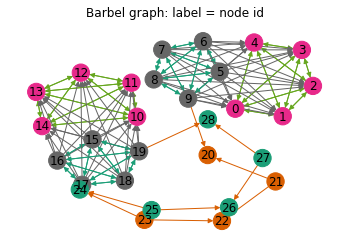

In [4]:
# load and show barbell graph
import networkx as nx
G =  nx.read_gpickle("/Users/tonpoppe/Downloads/graph.pickle")

plt.subplot(111)
# # pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)
color = [G.out_degree(x) for x in range(G.number_of_nodes())]
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
options = {
'node_color': color,
'node_size': 300,
'edgelist':edges,
'edge_color':weights,
'width': 1,
'with_labels': True,
'pos': pos,
'edge_cmap': plt.cm.Dark2,
'cmap': plt.cm.Dark2
}
nx.draw(G, **options)
plt.title("Barbel graph: label = node id")
plt.show()

In [5]:
def create_node_df(G):
    nodes = G.nodes(data=True)
    pdf = pd.DataFrame([[k] + list(v.values()) for k,v in nodes], columns= ['id', 'attr1', 'attr2', 'label'])
    return spark.createDataFrame(pdf)

def create_edges_df(G, lbls):
    edges = G.edges(data=True)
    pdf = pd.DataFrame([[s, d]+list(a.values()) for (s,d,a) in edges],
                        columns=lbls
    )
    return spark.createDataFrame(pdf)  

nodes = create_node_df(G)
edges = create_edges_df(G, ['src', 'dst', 'weight'])
graph = (nodes, edges)

In [6]:
# instantie graphframes variant with position encoding
from GAE.position_manager import PositionManager
from GAE.data_feeder_graphframes import DataFeederGraphFrames
gae = GraphAutoEncoder(
    graph, support_size=[3, 3], dims=[2, 6, 6, 4], batch_size=3, hub0_feature_with_neighb_dim=2, encoder_labels=['attr1', 'attr2'],
    useBN=True, verbose=True, seed=1, learning_rate=0.002, act=tf.nn.relu, pos_enc_cls=PositionManager,
    data_feeder_cls=DataFeederGraphFrames
)

The following node labels are included ['attr1', 'attr2']


The following edge labels are included ['weight']
start creating position dict at 1685695321.5701928
pos dictionary created in 0.01923203468322754 second: 1685695321.5894248


2023-06-02 10:42:01.567403: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


train nodes [13 17 16 11 10 26  4 14  6  1] ...
val nodes [20  8  5 28 21 19 25 24  9] ...


train nodes [13 17 16 11 10 26  4 14  6  1] ...
val nodes [20  8  5 28 21 19 25 24  9] ...
Epoch 1/30
6/6 [==============================] - 0s 73ms/step - loss: 0.4418 - output_1_loss: 0.2510 - output_2_loss: 0.1909 - val_loss: 0.3503 - val_output_1_loss: 0.2293 - val_output_2_loss: 0.1209
Epoch 2/30
6/6 [==============================] - 0s 72ms/step - loss: 0.4410 - output_1_loss: 0.2478 - output_2_loss: 0.1932 - val_loss: 0.3430 - val_output_1_loss: 0.2258 - val_output_2_loss: 0.1172
Epoch 3/30
6/6 [==============================] - 0s 75ms/step - loss: 0.4249 - output_1_loss: 0.2395 - output_2_loss: 0.1855 - val_loss: 0.3365 - val_output_1_loss: 0.2228 - val_output_2_loss: 0.1138
Epoch 4/30
6/6 [==============================] - 0s 90ms/step - loss: 0.4110 - output_1_loss: 0.2315 - output_2_loss: 0.1795 - val_loss: 0.3288 - val_output_1_loss: 0.2189 - val_output_2_loss: 0.1099
Epoch 5/30
6/6 [==============================] - 0s 70ms/step - loss: 0.4044 - output_1_loss: 0.2420 - o

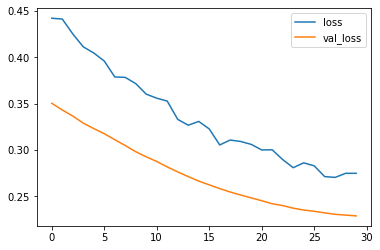

In [8]:
history = gae.fit(epochs=30, layer_wise=False)

plt.plot(history[None].history['loss'], label='loss')
plt.plot(history[None].history['val_loss'], label='val_loss')
plt.legend()
plt.show()

l1 structure has shape (1, 48, 8)


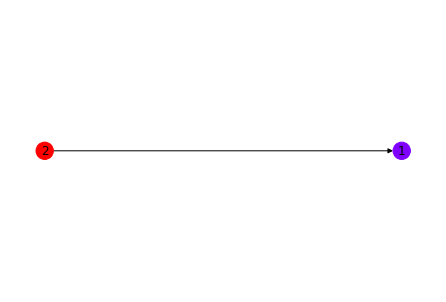

In [17]:
NODE_ID = 1
l1_struct, graph2 = gae.get_l1_structure(NODE_ID, show_graph=False, node_label='node_id', deduplicate=True)
print(f"l1 structure has shape {l1_struct.shape}")
nt = GraphReconstructor().show_graph(graph2)
# nt.show()

In [19]:
gae.sampler.get_features(9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5, 0.3], dtype=float32)>

In [15]:
np.set_printoptions(linewidth=110)
l1_struct[0]

<tf.Tensor: shape=(48, 8), dtype=float32, numpy=
array([[1.        , 1.        , 0.        , 0.        , 0.        , 0.6       , 0.5       , 0.3       ],
       [1.        , 0.6666667 , 0.        , 0.        , 0.        , 0.6       , 0.5       , 0.3       ],
       [1.        , 0.33333334, 0.        , 0.        , 0.        , 0.6       , 0.5       , 0.3       ],
       [1.        , 0.33333334, 0.        , 0.33333334, 0.        , 0.6       , 0.5       , 0.3       ],
       [1.        , 1.        , 0.        , 0.        , 0.        , 0.6       , 0.5       , 0.3       ],
       [1.        , 0.        , 1.        , 0.        , 0.        , 1.        , 0.3       , 0.7       ],
       [1.        , 0.        , 0.6666667 , 0.        , 0.        , 1.        , 0.3       , 0.7       ],
       [1.        , 0.        , 0.33333334, 0.        , 0.        , 1.        , 0.3       , 0.7       ],
       [1.        , 0.6666667 , 0.        , 0.        , 0.        , 0.6       , 0.5       , 0.3       ],
      